# Setting

In [2]:
# Base
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
from time import time
import itertools
import joblib
import os

#NLP
import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud 
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import string
from textblob import TextBlob


#ML
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
# from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
#from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Gdrive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# Function that remove the punctuation

def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

In [4]:
# Import Lemmatized dataset 
df = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Datasets/df_lemmatized.csv')
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

# Classification

In [5]:
classification_df = df[['Score', 'Lemmatized Text']]

Text(0, 0.5, 'Number of reviews')

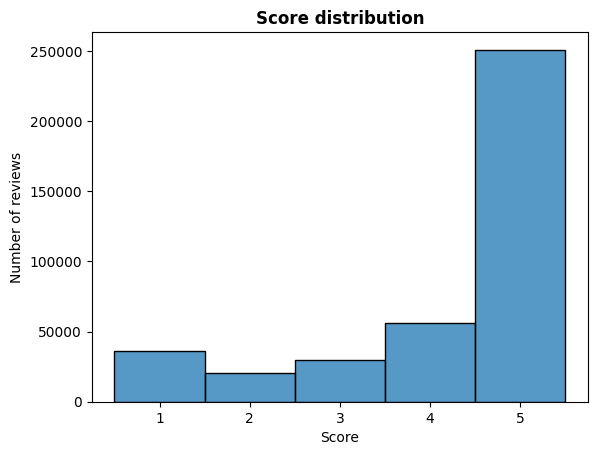

In [ ]:
sns.histplot(classification_df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [ ]:
print(classification_df['Score'].value_counts()/len(classification_df['Score']));

Le classi sono fortemente sbilanciate, con quasi il 78% delle review appartenenti alla classe 4 e 5. E' necessaria una procedura di resampling, in modo tale che i classificatori non diano stime distorte (classificando tutte le review come appartenenti alla classe 5 si otterrebbe comunque il 63% di accuratezza).

In [6]:
# define a sample size by considering the total number of reviews belonging to the minority class
sample_size = classification_df.groupby('Score').count().min()[0]

In [7]:
df_downsampled = classification_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

,Score,Lemmatized Text
308265,1,"[well, aware, marbury, make, excellent, produc..."
44428,1,"[grew, drinking, real, coronet, water, product..."
105692,1,"[product, smoked, baby, class, full, sand, ena..."
128243,1,"[product, description, say, includes, pack, se..."
5487,1,"[reviewed, florida, extremely, kind, reviewthi..."
...,...,...
196647,5,"[addicted, drink, however, add, tablespoon, va..."
238662,5,"[tried, many, health, bar, snack, ffactor, bes..."
271614,5,"[coronet, oil, excellent, multipurpose, produc..."
80969,5,"[org, stuff, organ, bag, seriously, far, favor..."


In [ ]:
df_downsampled.shape

Text(0, 0.5, 'Number of reviews')

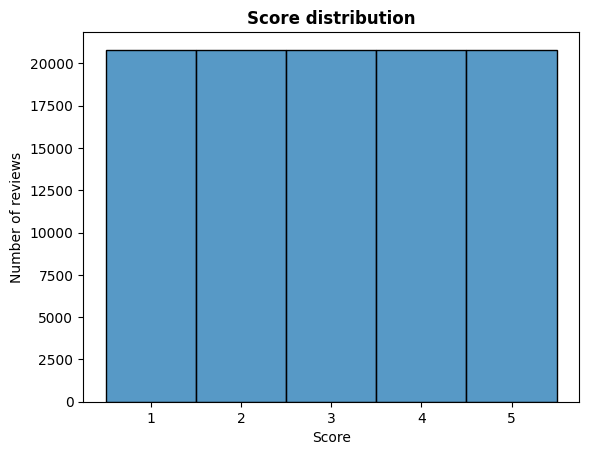

In [10]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [11]:
# Split training test set 
X_train, X_test, y_train, y_test = train_test_split(df_downsampled['Lemmatized Text'], 
                                                    df_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=df_downsampled['Score'])

# **Multi-label classification**

## **1 - Bag-of-Word**

In [8]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(X_train.astype(str)) 
X_train_BOW = cv_model.transform(X_train.astype(str))

In [ ]:
X_train_BOW.shape

Devo necessariamente ridurre la dimensionalità della matrice. Applico una SVD senza assegnare il numero di componenti da considerare e poi usiamo la funzione cusum() per ottenere la varianza cumulata, quindi teniamo un numero di componenti necessarie per raggiungere una certa soglia di varianza cumulata (fissata a priori).

Considerando l'elevata dimensionalità del dataset, non è possibile stimare l'intera SVD. Viene quindi considerato un numero comunque elevato di componenti, e.g. 1000, per poi andare a valutare la varianza cumulata. 

In [ ]:
# Run SVD with 3000 components

# n_components = 3000
# tSVD_BOW = TruncatedSVD(n_components = n_components)
# SVD_BOW = tSVD_BOW.fit(X_train_BOW)

# Cumulative varianca
# cum_var = np.cumsum(SVD_BOW.explained_variance_ratio_)

# Save fit in local 

# joblib.dump(SVD_BOW, "SVD_BOW_3000.joblib")

In [20]:
# Upload SVD

SVD_BOW_3000 = joblib.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_3000.joblib")
cum_var = np.cumsum(SVD_BOW_3000.explained_variance_ratio_)

In [ ]:
# Plot cumulative variance
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.show()

Fissiamo una threshold pari all'85%. Ciò vuol dire che andremo a considerare un numero di componenti necessarie per arrivare ad una varianza spiegata pari all'85%

In [21]:
threshold = 0.85
n_components = np.argmax(cum_var >= threshold) + 1
print("Numero di componenti necessariea spiegare una varianza pari all'85% sono : ", n_components)

Numero di componenti necessariea spiegare una varianza pari all'85% sono :  1413


In [22]:
# # SVD with optimal components

# tSVD_BOW = TruncatedSVD(n_components = 1413)
# SVD_BOW = tSVD_BOW.fit(X_train_BOW)

In [23]:
# # Apply the trasfrom on training and test set

# X_train_BOW = tSVD_BOW.transform(X_train_BOW)

# X_test_BOW = cv_model.transform(X_test.astype(str))
# X_test_BOW = tSVD_BOW.transform(X_test_BOW)

In [26]:
# # Save final dataset 

# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_train_BOW.npy', X_train_BOW)
# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_test_BOW.npy', X_test_BOW)

In [9]:
# Load dataset
X_train_BOW = np.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_train_BOW.npy')
X_test_BOW = np.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_test_BOW.npy')

### Algorithm Implementation

- Logistic Regression
- Random Forest
- K-NN
- XGboost

#### Logistic Regression

In [ ]:
# model = LogisticRegression(random_state=1)

# # Fine tuning

# solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [500, 200, 100, 50, 10, 1.0, 0.1, 0.01, 0.001]

# Define the grid search

# grid = dict(solver=solvers,penalty=penalty,C=c_values)

# Start the clock, train the classifier, then stop the clock
# start = time()

# Cross validation and Tuning
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW, y_train)

# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Save the results of the tuning 

# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/logreg_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

In [10]:
# Upload fitted model
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/BOW/logreg_gridsearch_BOW.joblib'
loaded_grid_search = joblib.load(path)

# Results summary
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save the model with the best performance
model_lr_BOW = loaded_grid_search.best_estimator_

Best result: 0.485791 using {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}


#### Random Forest

In [ ]:
# model = RandomForestClassifier()

# Fine tuning
# n_estimators = [10, 100, 1000]
# max_features = ['sqrt', 'log2']

# Define the grid reasearch
# grid = dict(n_estimators=n_estimators,max_features=max_features)

# Start the clock, train the classifier, then stop the clock
# start = time()

# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2, scoring='accuracy', error_score=0)
# grid_result = grid_search.fit(X_train_BOW, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/rf_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

In [12]:

# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/BOW/rf_gridsearch_BOW.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_rf_BOW = loaded_grid_search.best_estimator_

Best result: 0.375527 using {'max_features': 'sqrt', 'n_estimators': 1000}


#### K-NN

In [ ]:
# model = KNeighborsClassifier(weights='distance')
# # Parametri critici da
# n_neighbors = range(1, 21, 4)

# # Definisco la griglia di ricerca
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))
# # Summary dei risultati
# print("Best result: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

In [14]:
# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/BOW/knn_gridsearch_BOW.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_knn_BOW = loaded_grid_search.best_estimator_

Best result: 0.319585 using {'n_neighbors': 17}


#### XG-Boost

In [ ]:
# le = LabelEncoder()
# y_train_xg = le.fit_transform(y_train)

# # XG-Boost con ottimizzazione degli iperparametri
# model = XGBClassifier( tree_method = 'gpu_hist', predictor = 'gpu_predictor')

# # Parametri critici da ottimizzare
# max_depth = [1,2,3, 4, 5, 6, 7, 8, 9]
# eta  = [0.001, 0.01, 0.01, 0.2, 0.4, 0.6, 0.8]
# colsample_bytree = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
# sampling_method = ['uniform', 'gradient_based']

# #Definisco la griglia di ricerca
# grid = dict(max_depth=max_depth, eta =eta, colsample_bytree = colsample_bytree, sampling_method = sampling_method)

# # Start the clock, train the classifier, then stop the clock
# start = time()
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter= 6, cv=2, scoring='accuracy', error_score=0, n_jobs=-1, random_state=0, verbose=4)
# grid_result = random_search.fit(X_train_BOW, y_train_xg)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

# # Salvataggio dei risultati del tuning Google-Colab
# # model_path = '/content/gdrive/MyDrive/TextMiningProject/xgboost_gridsearch_BOW.joblib'
# # joblib.dump(grid_result, model_path)

In [15]:
# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/BOW/xgboost_gridsearch_BOW.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_xgboost_BOW = loaded_grid_search.best_estimator_

Best result: 0.413065 using {'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.5}


### Analysis of results

In [26]:
models = [model_lr_BOW, model_rf_BOW, model_knn_BOW, model_xgboost_BOW]

# Make a prediction on the test set
results = []
for model in models:
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test)
        print(y_test_xg)
        y_pred = model.predict(X_test_BOW)
        acc = accuracy_score(y_test_xg, y_pred)
        prec = precision_score(y_test_xg, y_pred, average='macro')
        recall = recall_score(y_test_xg, y_pred, average='macro')
        f1 = f1_score(y_test_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_BOW)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Dataframe with the results for each model
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'RF model', 'KNN model', 'XGBOOST model']
print(df_results)

NameError: name 'model_lr_BOW' is not defined

In [67]:
# Save results dataframe
df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_BOW.csv')

In [68]:
# Load results dataframe
results_BOW = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_BOW.csv')

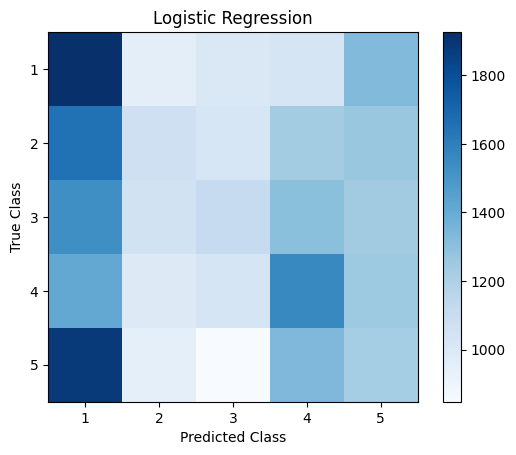

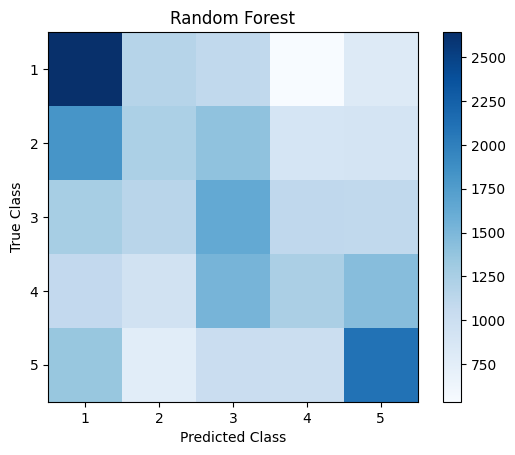

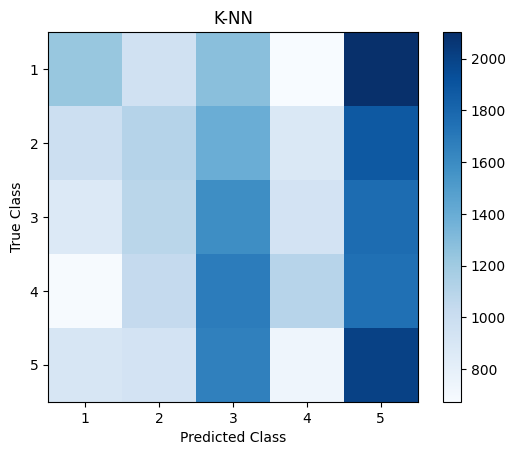

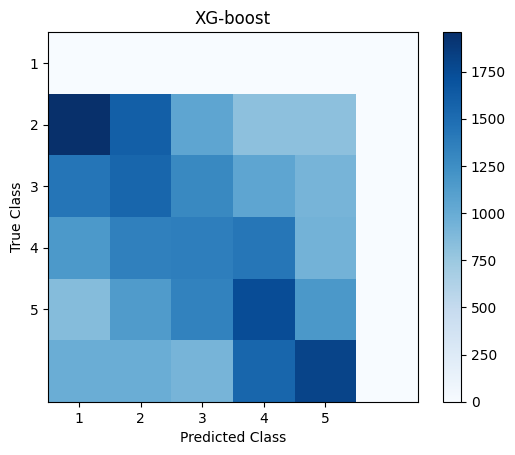

<Figure size 640x480 with 0 Axes>

In [69]:
models = [model_lr_BOW, model_rf_BOW, model_knn_BOW, model_xgboost_BOW]
model_names = ["Logistic Regression", "Random Forest", "K-NN", "XG-boost"]
os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper')
# Confusion matrix for each model
for i, model in enumerate(models):
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test_xg)
        conf_matrix = confusion_matrix(y_test, model.predict(X_test_BOW))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks( np.arange(5),classes)
        plt.yticks( np.arange(5), classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        plt.savefig(model_names[i] + '_confusion_matrix.png')
        plt.show()
        plt.clf()
    else:
        conf_matrix = confusion_matrix(y_test, model.predict(X_test_BOW))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks(np.arange(5), classes)
        plt.yticks(np.arange(5), classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        plt.savefig(model_names[i] + '_confusion_matrix.png')
        plt.show()
        plt.clf()


## **2 - TF-IDF**

In [12]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True) 
tv_model = tv.fit(X_train.astype(str)) 
X_train_TFIDF = tv.transform(X_train.astype(str)) # Vettorizzo

In [ ]:
X_train_TFIDF.shape

In [ ]:
# Run SVD with 5000 components

# n_components = 5000
# tSVD_TFIDF = TruncatedSVD(n_components = n_components)
# SVD_TFIDF_5000 = tSVD_TFIDF.fit(X_train_TFIDF)

# Cumulative variance
# cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

# Save SVD on the disk
# joblib.dump(SVD_TFIDF_5000, "SVD_TFIDF_5000.joblib")


In [ ]:
# Upload SVD
SVD_TFIDF_5000 = joblib.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_TFIDF_5000.joblib")
cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

In [ ]:
# Cumulative variance plot
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.show()

In [ ]:
threshold = 0.85
n_components = np.argmax(cum_var >= threshold) + 1
print("Numero di componenti necessariea spiegare una varianza pari all'85% sono : ", n_components)

In [64]:
# # IFit optimal SVD
# tSVD_TFIDF = TruncatedSVD(n_components = 4719)
# SVD_TFIDF = tSVD_TFIDF.fit(X_train_TFIDF)

In [65]:
# # Aplly the trasformation on the training and test set
# X_train_TFIDF = tSVD_TFIDF.transform(X_train_TFIDF)

# X_test_TFIDF = tv_model.transform(X_test.astype(str))
# X_test_TFIDF = SVD_TFIDF.transform(X_test_TFIDF)

In [67]:
# Save final datasets

# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_TFIDF/X_train_TFIDF.npy', X_train_TFIDF)
# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_TFIDF/X_test_TFIDF.npy', X_test_TFIDF)

In [16]:
# Load datasets

X_train_TFIDF = np.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_TFIDF/X_train_TFIDF.npy')
X_test_TFIDF = np.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_TFIDF/X_test_TFIDF.npy')

### Algorithm Implementation

- Logistic Regression
- KNN
- Random Forest
- XGBoost

#### Logistic regression

In [ ]:
# # Regressione logistica con ottimizzazione degli iperparametri
# model = LogisticRegression(random_state=1)

# # Iperparametri "critici" da ottimizzare 
# solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [500, 200, 100, 50, 10, 1.0, 0.1, 0.01, 0.001]

# # Definisco la griglia di ricerca
# grid = dict(penalty=penalty,C=c_values)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# # CV and Tuning
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_TFIDF, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Salvataggio dei risultati del tuning
# # path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/lrr_gridsearch_TFIDF.joblib'
# # joblib.dump(grid_result, path)

# model_path = '/content/gdrive/MyDrive/TextMiningProject/logreg_gridsearch_TFIDF.joblib'
# joblib.dump(grid_result, model_path)

In [17]:
# Caricamento del risultato del tuning

path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/TFIDF/logreg_gridsearch_TFIDF.joblib'
loaded_grid_search = joblib.load(path)
# model_path = '/content/gdrive/MyDrive/TextMiningProject/logreg_gridsearch_TFIDF.joblib'
# loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

#Salvo il modello con le migliori performance
model_lr_TFIDF = loaded_grid_search.best_estimator_

Best result: 0.443364 using {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.001}


#### K-NN

In [ ]:
# model = KNeighborsClassifier(weights='distance')
# # Parametri critici da
# n_neighbors = range(1, 21, 1)

# # Definisco la griglia di ricerca
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# #grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2, scoring='accuracy',error_score=0)
# grid_result = random_search.fit(X_train_TFIDF, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Salvataggio dei risultati del tuning

# # path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_TFIDF.joblib'
# # loaded_grid_search = joblib.load(path)
# model_path = '/content/gdrive/MyDrive/TextMiningProject/knn_gridsearch_TFIDF.joblib'
# joblib.dump(grid_result, model_path)

In [18]:
# Caricamento del risultato del tuning

path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/TFIDF/knn_gridsearch_TFIDF.joblib'
loaded_grid_search = joblib.load(path)
# model_path = '/content/gdrive/MyDrive/TextMiningProject/knn_gridsearch_TFIDF.joblib'
# loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_knn_TFIDF = loaded_grid_search.best_estimator_

Best result: 0.237697 using {'n_neighbors': 20}


#### Random Forest

In [ ]:
# # Random Forest
# model = RandomForestClassifier()

# # Parametri 'critici' da ottimizzare
# max_depth = [1, 2, 3, 4, 5, 6, 7]
# n_estimators = [10, 100, 200, 400, 600, 800, 1000]
# max_features = ['sqrt', 'log2']
# # Definisco la griglia di ricerca 
# grid = dict(n_estimators=n_estimators,max_features=max_features, max_depth = max_depth)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_TFIDF, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/rf_gridsearch_TFIDF.joblib'
# joblib.dump(grid_result, path)

In [23]:

# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/TFIDF/rf_gridsearch_TFIDF.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_rf_TFIDF = loaded_grid_search.best_estimator_

Best result: 0.371407 using {'n_estimators': 1000, 'max_features': 'sqrt'}


#### XGBoost

In [29]:
# le = LabelEncoder()
# y_train_xg = le.fit_transform(y_train)

# model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective='multi:softmax')
# model_xgboost_TFIDF = model.fit(X_train_TFIDF, y_train_xg)

# # Salvataggio dei risultati dell'holdout
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/TFIDF/xgboost_holdout_TFIDF.joblib'
# joblib.dump(model_xgboost_TFIDF, path)

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_holdout_TFIDF.joblib']

In [20]:
# Caricamento del risultato dell'holdout
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/TFIDF/xgboost_holdout_TFIDF.joblib'
model_xgboost_TFIDF = joblib.load(path)

### Analysis of the results

In [ ]:
models = [model_lr_TFIDF, model_knn_TFIDF, model_rf_TFIDF, model_xgboost_TFIDF]

# Previsioni sul test set
results = []
for model in models:
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test)
        print(y_test_xg)
        y_pred = model.predict(X_test_TFIDF)
        acc = accuracy_score(y_test_xg, y_pred)
        prec = precision_score(y_test_xg, y_pred, average='macro')
        recall = recall_score(y_test_xg, y_pred, average='macro')
        f1 = f1_score(y_test_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_TFIDF)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Creo la tabella e visualizzo i risultati
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', "Random Forest" XGBOOST model']
print(df_results)

In [38]:
# Dataframe with the results for each models

df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', "Random Forest" , 'XGBOOST model']
print(df_results)

               Accuracy  Precision    Recall  F1 Score
LR model       0.313976   0.305260  0.313967  0.293167
KNN model      0.220299   0.214467  0.220295  0.172065
Random Forest  0.291703   0.286056  0.291697  0.286066
XGBOOST model  0.429254   0.420693  0.429246  0.423616


In [44]:
#  Save the results
df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_TFIDF.csv')

In [72]:
# Carico i risultati 
results_TFIDF = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_TFIDF.csv')
print(results_TFIDF)

      Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0       LR model  0.313976   0.305260  0.313967  0.293167
1      KNN model  0.220299   0.214467  0.220295  0.172065
2  Random Forest  0.291703   0.286056  0.291697  0.286066
3  XGBOOST model  0.429254   0.420693  0.429246  0.423616


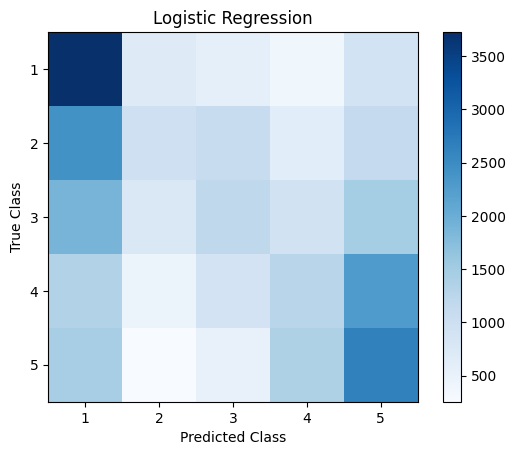

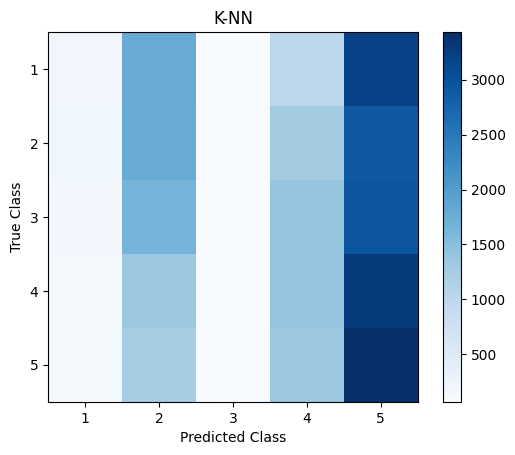

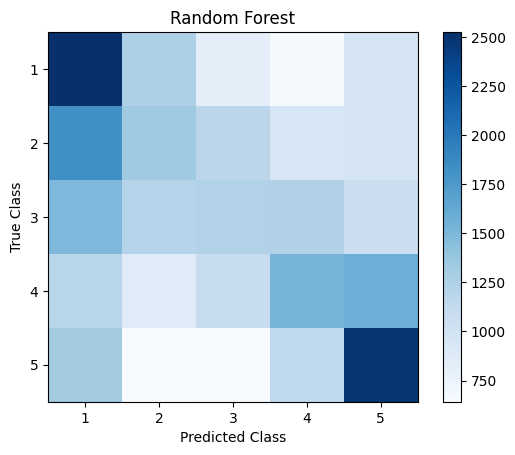

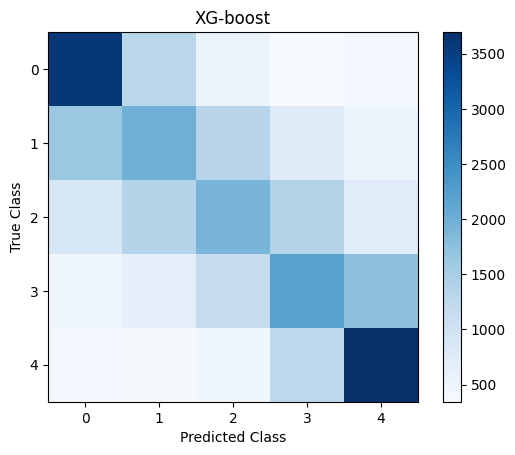

<Figure size 640x480 with 0 Axes>

In [73]:
models = [model_lr_TFIDF, model_knn_TFIDF, model_rf_TFIDF, model_xgboost_TFIDF]
model_names = ["Logistic Regression", "K-NN", "Random Forest", "XG-boost"]
os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Multiclasse')
# Matrici di Confusione
for i, model in enumerate(models):
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test)
        conf_matrix = confusion_matrix(y_test_xg, model.predict(X_test_TFIDF))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        tick_marks = np.arange(5)
        plt.xticks(tick_marks, np.arange(5))
        plt.yticks(tick_marks, np.arange(5))
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        plt.savefig(model_names[i] + '_confusion_matrix.png')
        plt.show()
        plt.clf()
    else:
        conf_matrix = confusion_matrix(y_test, model.predict(X_test_TFIDF))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks(np.arange(5), classes)
        plt.yticks(np.arange(5), classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        plt.savefig(model_names[i] + '_confusion_matrix_TFIDF.png')
        plt.show()
        plt.clf()

## **3 - Word2Vec**

https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

In [18]:
# Fit the w2v model on the training dataset
w2v_model = gensim.models.Word2Vec(X_train, vector_size=300, window=8, min_count=2)

Ho a disposizione il modello W2V, che ha convertito ogni parola presente nel training (nello specifico, deve essere presente almeno
due volte --> min_count=2) in un vettore a 100 componenti. Per generare un vettore rappresentativo di ciascuna review andrò a creare un
vettore costituito dalla media (componente per componente) dei vettori delle parole appartenenti alla review.

In [ ]:
words = set(w2v_model.wv.index_to_key) # Lista di parole presenti nel modello W2V

# # Creo due liste, una per il training e una per il test. Ciascuna lista contiene come elementi delle altre liste. 
# # Ciascun elemento (ciascuna lista) contiene i vettori relativi alle parole di una specifica review (una lista per review contenente i vettori delle singole parole)

# X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
#                          for ls in X_train])
# X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
#                          for ls in X_test])

In [22]:
# Load X_train_vect and X_test_vect
X_train_vect = np.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_W2V/X_train_vect.npy", allow_pickle=True)
X_test_vect = np.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_W2V/X_test_vect.npy", allow_pickle=True)

Per spiegare meglio quanto fatto sopra uso questo esempio:

In [ ]:
# La prima review del training è la seguente
X_train.head(1)

In [ ]:
# Le prime due parole sono 'love' e 'walker'. Stampo i vettori di queste due parole
w2v_model.wv.get_vector('love')

In [ ]:
w2v_model.wv.get_vector('walker')

Per vedere che sono identici, stampo i primi due elementi della prima lista in X_train_vec. Questi due elementi corrispondono ai vettori delle prime due parole della review selezionata, ossia 'love' e 'walker'

In [ ]:
X_train_vect[0][0]

In [ ]:
X_train_vect[0][1]

Andremo a fare un loop su queste liste. Ogni frase avrà un diverso numero di parole e di conseguenza un numero differente di array da mediare

In [78]:
# Final datasets

X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(300, dtype=float))

In [ ]:
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

Come si vede dal for eseguito qui sopra, ogni frase, indipendentemente dal numero di parole che la compongono, corrisponde a un vettore con 300 componenti, creato nello specifico mediando i vettori delle singole parole componente per componente.

### Algorithm Implementation

- Regressione Logistica
- Random Forest
- SVM
- XGBoost

##### Logistic Regression

In [ ]:
# # Regressione logistica con ottimizzazione degli iperparametri
# model = LogisticRegression(random_state=1)

# # Iperparametri "critici" da ottimizzare 
# solvers = ['lbfgs', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [500, 200, 100, 50, 10]

# # Definisco la griglia di ricerca
# grid = dict(penalty=penalty,C=c_values, solver = solvers)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# # CV and Tuning
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_vect_avg, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/lrr_gridsearch_W2V.joblib'
# joblib.dump(grid_result, path)

# # model_path = '/content/gdrive/MyDrive/TextMiningProject/logreg_gridsearch_W2V.joblib'
# # joblib.dump(grid_result, model_path)

In [24]:
# Caricamento del risultato del tuning

path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/W2V/lrr_gridsearch_W2V.joblib'
loaded_grid_search = joblib.load(path)
# model_path = '/content/gdrive/MyDrive/TextMiningProject/logreg_gridsearch_W2V.joblib'
# loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

#Salvo il modello con le migliori performance
model_lr_W2V = loaded_grid_search.best_estimator_

Best result: 0.472592 using {'solver': 'saga', 'penalty': 'l2', 'C': 200}


#### Random Forest

In [54]:
# from sklearn.model_selection import RandomizedSearchCV
# # Random Forest
# model = RandomForestClassifier()

# # # Parametri 'critici' da ottimizzare
# n_estimators = [10, 50, 70, 100, 200, 300, 400, 500]
# max_features = ['sqrt', 'log2']
# # #Definisco la griglia di ricerca 
# grid = dict(n_estimators=n_estimators,max_features=max_features)

# # # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_vect_avg, y_train) 
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Salvataggio dei risultati del tuning
# joblib.dump(grid_result, 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/W2V/rf_gridsearch_W2V.joblib')

# # model_path = '/content/gdrive/MyDrive/TextMiningProject/rf_gridsearch_w2v.joblib'
# # joblib.dump(grid_result, model_path)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_features=sqrt, n_estimators=500;, score=0.432 total time= 8.2min
[CV 2/2] END max_features=sqrt, n_estimators=500;, score=0.435 total time= 8.0min
[CV 1/2] END max_features=sqrt, n_estimators=100;, score=0.422 total time= 1.6min
[CV 2/2] END max_features=sqrt, n_estimators=100;, score=0.419 total time= 1.8min
[CV 1/2] END max_features=log2, n_estimators=200;, score=0.428 total time= 2.0min
[CV 2/2] END max_features=log2, n_estimators=200;, score=0.428 total time= 2.1min
[CV 1/2] END max_features=log2, n_estimators=70;, score=0.414 total time=  45.3s
[CV 2/2] END max_features=log2, n_estimators=70;, score=0.412 total time=  33.2s
[CV 1/2] END max_features=log2, n_estimators=10;, score=0.346 total time=   4.7s
[CV 2/2] END max_features=log2, n_estimators=10;, score=0.348 total time=   4.6s
[CV 1/2] END max_features=sqrt, n_estimators=200;, score=0.429 total time= 3.7min
[CV 2/2] END max_features=sqrt, n_estimato

In [26]:

# # Caricamento del risultato del tuning
loaded_grid_search = joblib.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/W2V/rf_gridsearch_W2V.joblib')

# # Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# # Salvo il modello con le migliori perfomance
model_rf_W2V = loaded_grid_search.best_estimator_

Best result: 0.433420 using {'n_estimators': 500, 'max_features': 'sqrt'}


#### KNN

In [ ]:
# model = KNeighborsClassifier(weights='distance')
# # Parametri critici da
# n_neighbors = range(1, 21, 1)

# # Definisco la griglia di ricerca
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# #grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2, scoring='accuracy',error_score=0)
# grid_result = random_search.fit(X_train_vect_avg, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# # Salvataggio dei risultati del tuning

# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_W2V.joblib'
# joblib.dump(grid_result, path)
# # model_path = '/content/gdrive/MyDrive/TextMiningProject/knn_gridsearch_W2V.joblib'
# # joblib.dump(grid_result, model_path)

In [28]:
# Caricamento del risultato del tuning

path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/W2V/knn_gridsearch_W2V.joblib'
loaded_grid_search = joblib.load(path)
# model_path = '/content/gdrive/MyDrive/TextMiningProject/knn_gridsearch_W2V.joblib'
# loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_knn_W2V = loaded_grid_search.best_estimator_

Best result: 0.374360 using {'n_neighbors': 20}


#### XGBoost

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# from xgboost import XGBClassifier
# from sklearn.model_selection import RandomizedSearchCV

# le = LabelEncoder()
# y_train_xg = le.fit_transform(y_train)

# model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective='multi:softmax')
# model_xgboost_W2V = model.fit(X_train_vect_avg, y_train_xg)

# # Salvataggio dei risultati dell'holdout
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_holdout_W2V.joblib'
# joblib.dump(model_xgboost_W2V, path)

In [29]:
# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_Multiclasse/W2V/xgboost_holdout_W2V.joblib'
model_xgboost_W2V = joblib.load(path)

# model_path = '/content/gdrive/MyDrive/TextMiningProject/xgboost_holdout_W2V.joblib'
# model_xgboost_W2V = joblib.load(model_path)

### Analysis of the results

In [59]:
models = [model_lr_W2V, model_knn_W2V, model_rf_W2V, model_xgboost_W2V]

# Previsioni sul test set
results = []
for model in models:
    if model == models[3]:
        y_test_xg = le.fit_transform(y_test)
        print(y_test_xg)
        y_pred = model.predict(X_test_vect_avg)
        acc = accuracy_score(y_test_xg, y_pred)
        prec = precision_score(y_test_xg, y_pred, average='macro')
        recall = recall_score(y_test_xg, y_pred, average='macro')
        f1 = f1_score(y_test_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_vect_avg)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Creo la tabella e visualizzo i risultati
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', 'Random Forest model', 'XGBOOST model']
print(df_results)

[3 2 1 ... 4 3 2]
                     Accuracy  Precision    Recall  F1 Score
LR model             0.472935   0.464525  0.472927  0.467340
KNN model            0.385476   0.396524  0.385471  0.389232
Random Forest model  0.447585   0.435090  0.447577  0.438207
XGBOOST model        0.453097   0.444104  0.453089  0.447424


In [60]:
# Save results dataframe
df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_W2V.csv')

In [76]:
results_W2V = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_W2V.csv')
print(results_W2V)

            Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0             LR model  0.472935   0.464525  0.472927  0.467340
1            KNN model  0.385476   0.396524  0.385471  0.389232
2  Random Forest model  0.447585   0.435090  0.447577  0.438207
3        XGBOOST model  0.453097   0.444104  0.453089  0.447424


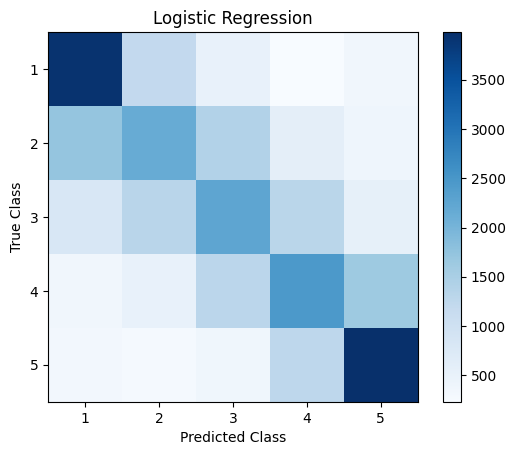

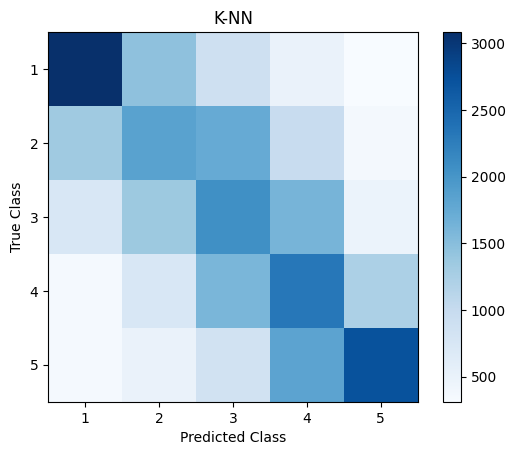

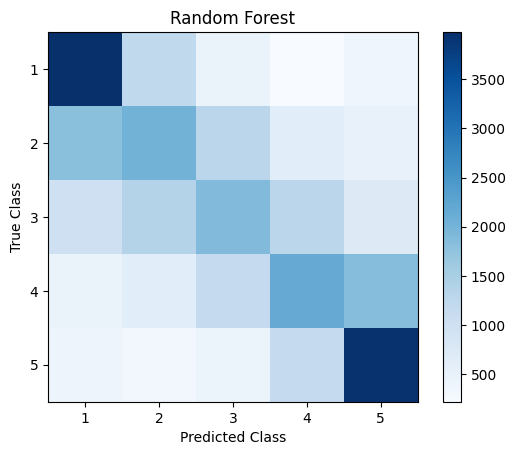

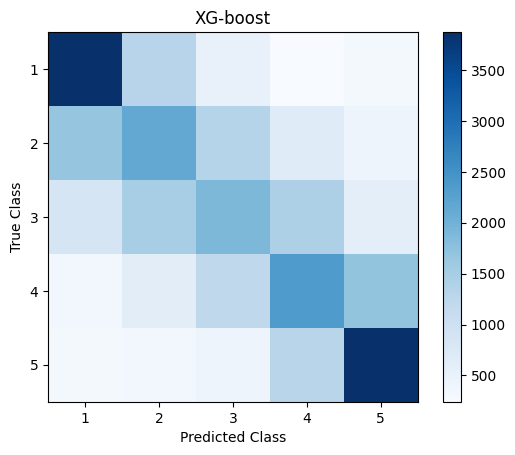

<Figure size 640x480 with 0 Axes>

In [79]:
models = [model_lr_W2V, model_knn_W2V, model_rf_W2V, model_xgboost_W2V]
model_names = ["Logistic Regression", "K-NN", "Random Forest", "XG-boost"]

os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper')
# Calcola e visualizza le matrici di confusione per ogni modello
for i, model in enumerate(models):
    if model == models[3]:
        le = LabelEncoder()
        y_test_xg = le.fit_transform(y_test)
        conf_matrix = confusion_matrix(y_test_xg, model.predict(X_test_vect_avg))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks(np.arange(5),  classes)
        plt.yticks(np.arange(5),  classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        plt.savefig(model_names[i] + '_confusion_matrix_W2V.png')
        plt.show()
        plt.clf()
    else:
        conf_matrix = confusion_matrix(y_test, model.predict(X_test_vect_avg))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.colorbar()
        classes = [1,2,3,4,5]
        plt.xticks(np.arange(5), classes)
        plt.yticks(np.arange(5), classes)
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title(model_names[i])
        plt.savefig(model_names[i] + '_confusion_matrix_W2V.png')
        plt.show()
        plt.clf()

# Binary Classification 

In [8]:
# Keep scores other than 3
df_binary = classification_df[classification_df['Score']!=3]

In [9]:
# Binary variable
df_binary.loc[df_binary.Score < 3, "Score"] = 0
df_binary.loc[df_binary.Score > 3, "Score"] = 1
df_binary.head()

,Score,Lemmatized Text
0,1,"[bought, several, vitality, canned, dog, food,..."
1,0,"[product, arrived, labelled, lumbo, halted, pe..."
2,1,"[connection, around, century, light, pillow, c..."
3,0,"[looking, secret, ingredient, robitussin, beli..."
4,1,"[great, staff, great, price, wide, assortment,..."


Text(0, 0.5, 'Number of reviews')

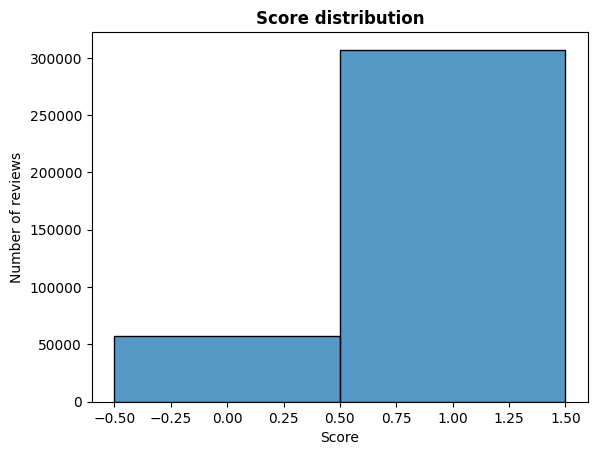

In [11]:
sns.histplot(df_binary['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [10]:
sample_size_binary = df_binary.groupby('Score').count().min()[0]
sample_size_binary

57108

In [11]:
binary_downsampled = df_binary.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size_binary))
binary_downsampled

,Score,Lemmatized Text
374220,0,"[provide, increase, energy, level, complete, w..."
74307,0,"[first, poorwasting, kombucha, worse, wonder, ..."
334540,0,"[sauerkraut, lobby, seemed, good, choice, prod..."
58198,0,"[ordered, received, quaker, minute, quick, wri..."
331139,0,"[drink, coffee, le, like, itunless, youre, mix..."
...,...,...
274389,1,"[nice, light, kettle, corn, tastewe, used, pop..."
379531,1,"[ok, like, fact, fresh, nodule, leg, lower, so..."
233165,1,"[ive, purchased, martelli, past, three, four, ..."
382925,1,"[know, know, people, dont, like, younger, use,..."


In [12]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(binary_downsampled["Lemmatized Text"], 
                                                    binary_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=binary_downsampled['Score'])

## **1 - Bag-of-Word**

In [13]:
cv_bin = CountVectorizer(min_df=0., max_df=1.0)
cv_model_bin = cv_bin.fit(X_train_bin.astype(str)) 
X_train_BOW_bin = cv_model_bin.transform(X_train_bin.astype(str))

In [31]:
X_train_BOW_bin.shape

(79951, 80905)

In [ ]:
# # Eseguo la SVD
# n_components = 3000
# tSVD_BOW_bin = TruncatedSVD(n_components = n_components)
# SVD_BOW_bin = tSVD_BOW_bin.fit(X_train_BOW_bin)

# # Calcolo varianza cumulata delle componenti
# cum_var = np.cumsum(SVD_BOW_bin.explained_variance_ratio_)

# # Salvo SVD su disco
# joblib.dump(SVD_BOW_bin, "H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_3000_bin.joblib")

In [16]:
# carico SVD
SVD_BOW_3000_bin = joblib.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_3000_bin.joblib")
cum_var = np.cumsum(SVD_BOW_3000_bin.explained_variance_ratio_)

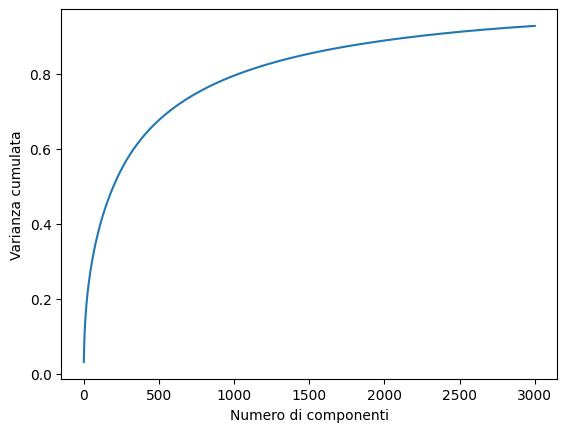

In [33]:
# Grafico varianza cumulata
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative Variance")
plt.show()

In [17]:
threshold = 0.85
n_components = np.argmax(cum_var >= threshold) + 1
print("Numero di componenti necessariea spiegare una varianza pari all'85% sono : ", n_components)

Numero di componenti necessariea spiegare una varianza pari all'85% sono :  1466


In [14]:
# # Stimo SVD ottimale
# tSVD_BOW_bin = TruncatedSVD(n_components = 1466)
# SVD_BOW_bin = tSVD_BOW_bin.fit(X_train_BOW_bin)

# # Salvo SVD ottimizzata
# joblib.dump(SVD_BOW_bin, "H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_bin_optim.joblib")

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_bin_optim.joblib']

In [15]:
# # Apply the trasformation on training and test set
# X_train_BOW_bin = tSVD_BOW_bin.transform(X_train_BOW_bin)

# X_test_BOW_bin = cv_model_bin.transform(X_test_bin.astype(str))
# X_test_BOW_bin = SVD_BOW_bin.transform(X_test_BOW_bin)

In [16]:
# # Save final datasets
# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_train_BOW_bin.npy', X_train_BOW_bin)
# np.save('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_test_BOW_bin.npy', X_test_BOW_bin)

In [36]:
# Load final datasets
X_train_BOW_bin = np.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_train_BOW_bin.npy')
X_test_BOW_bin = np.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_BOW/X_test_BOW_bin.npy')

In [28]:
X_test_BOW_bin.shape

(31203, 80905)

### Algorithm Implementation

##### Logistic Regression

In [44]:
# model = LogisticRegression(random_state=1)

# # Grid reasearch
# solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [900, 700, 500, 200, 100, 50, 10]
# grid = dict(solver=solvers,penalty=penalty,C=c_values)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW_bin, y_train_bin)
# # end = time()

# # Save fine tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/logreg_gridsearch_BOW_bin.joblib'
# joblib.dump(grid_result, path)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ....C=100, penalty=l2, solver=saga;, score=0.866 total time=  53.5s
[CV 2/2] END ....C=100, penalty=l2, solver=saga;, score=0.865 total time=  47.1s
[CV 1/2] END ......C=10, penalty=l2, solver=sag;, score=0.865 total time=  47.7s
[CV 2/2] END ......C=10, penalty=l2, solver=sag;, score=0.864 total time=  48.2s
[CV 1/2] END ....C=50, penalty=None, solver=sag;, score=0.000 total time=   0.1s
[CV 2/2] END ....C=50, penalty=None, solver=sag;, score=0.000 total time=   0.1s
[CV 1/2] END ..C=900, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 2/2] END ..C=900, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 1/2] END ..C=200, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 2/2] END ..C=200, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 1/2] END ..C=100, penalty=None, solver=saga;, score=0.000 total time=   0.1s
[CV 2/2] END ..C=100, penalty=None, solver=saga;,

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/logreg_gridsearch_BOW_bin.joblib']

In [37]:
# Load fine tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/logreg_gridsearch_BOW_bin.joblib'
loaded_grid_search = joblib.load(path)

# Best estimation
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save model with the best performance
model_lr_BOW_bin = loaded_grid_search.best_estimator_

Best result: 0.865443 using {'solver': 'saga', 'penalty': 'l2', 'C': 100}


##### Random Forest

In [55]:
model = RandomForestClassifier()

# Grid reasearch
max_depth = [1, 2, 3, 4, 5, 6, 7]
n_estimators = [10, 100, 200, 300, 500, 700, 1000]
max_features = ['sqrt', 'log2']
grid = dict(n_estimators=n_estimators,max_features=max_features, max_depth = max_depth)

# Start the clock, train the classifier, then stop the clock
start = time()

random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
grid_result = random_search.fit(X_train_BOW_bin, y_train_bin)
end = time()

# Save fine tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/rf_gridsearch_BOW_bin.joblib'
joblib.dump(grid_result, path)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_depth=4, max_features=sqrt, n_estimators=200;, score=0.734 total time= 3.1min
[CV 2/2] END max_depth=4, max_features=sqrt, n_estimators=200;, score=0.726 total time= 2.6min
[CV 1/2] END max_depth=4, max_features=log2, n_estimators=200;, score=0.677 total time=  35.3s
[CV 2/2] END max_depth=4, max_features=log2, n_estimators=200;, score=0.658 total time=  35.6s
[CV 1/2] END max_depth=6, max_features=log2, n_estimators=1000;, score=0.693 total time= 4.6min
[CV 2/2] END max_depth=6, max_features=log2, n_estimators=1000;, score=0.682 total time= 5.0min
[CV 1/2] END max_depth=7, max_features=sqrt, n_estimators=300;, score=0.744 total time= 5.9min
[CV 2/2] END max_depth=7, max_features=sqrt, n_estimators=300;, score=0.741 total time= 6.9min
[CV 1/2] END max_depth=3, max_features=log2, n_estimators=10;, score=0.635 total time=   2.9s
[CV 2/2] END max_depth=3, max_features=log2, n_estimators=10;, score=0.591 total tim

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/rf_gridsearch_BOW_bin.joblib']

In [40]:
# Load fine tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/rf_gridsearch_BOW_bin.joblib'
loaded_grid_search = joblib.load(path)

# Best estimation
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save model with the best performance
model_rf_BOW_bin = loaded_grid_search.best_estimator_

Best result: 0.865455 using {'solver': 'saga', 'penalty': 'l2', 'C': 500}


#### KNN

In [ ]:
# model = KNeighborsClassifier(weights='distance')

# # Grid reasearch
# n_neighbors = range(1, 21, 1)
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()

# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW_bin, y_train_bin)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))


# # Save fine tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimeted/Classificazione_binaria/BOW/knn_gridsearch_BOW_bin.joblib'
# joblib.dump(grid_result, path)

In [42]:
# Load fine tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/knn_gridsearch_BOW_bin.joblib'
loaded_grid_search = joblib.load(path)

# Best estimation
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Save model with the best performance
model_knn_BOW_bin = loaded_grid_search.best_estimator_

Best result: 0.702142 using {'n_neighbors': 20}


#### XGBoost

In [33]:
# from sklearn.preprocessing import LabelEncoder
# from xgboost import XGBClassifier
# from sklearn.model_selection import RandomizedSearchCV

# le = LabelEncoder()
# y_train_bin_xg = le.fit_transform(y_train_bin)

# model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective= 'binary:logistic')
# model_xgboost_BOW_bin = model.fit(X_train_BOW_bin, y_train_bin_xg)

# #Salvataggio dei risultati dell'holdout
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_holdout_BOW_bin.joblib'
# joblib.dump(model_xgboost_BOW_bin, path)

In [93]:
le.fit_transform(y_train_bin)

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [43]:
# Load model
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/BOW/xgboost_holdout_BOW_bin.joblib'
xgboost_holdout_BOW_bin = joblib.load(path)

In [90]:
xgboost_holdout_BOW_bin

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...)

### Analysis of the results

In [94]:
models = [model_lr_BOW_bin, model_knn_BOW_bin, model_rf_BOW_bin, xgboost_holdout_BOW_bin]

# Previsioni sul test set
results = []
for model in models:
    y_pred_bin = model.predict(X_test_BOW_bin)
    acc = accuracy_score(y_test_bin, y_pred_bin)
    prec = precision_score(y_test_bin, y_pred_bin, average='macro')
    recall = recall_score(y_test_bin, y_pred_bin, average='macro')
    f1 = f1_score(y_test_bin, y_pred_bin, average='macro')
    results.append([acc, prec, recall, f1])

# Dataframe with the results
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', 'Random Forest', 'XGBOOST model']
print(df_results)

               Accuracy  Precision    Recall  F1 Score
LR model       0.870626   0.870652  0.870626  0.870624
KNN model      0.548344   0.557556  0.548338  0.529502
Random Forest  0.870626   0.870652  0.870626  0.870624
XGBOOST model  0.544929   0.545483  0.544931  0.543543


In [85]:
# Save results dataframe
df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_BOW_bin.csv')

In [87]:
# Load results dataframe
results_BOW_bin = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_BOW_bin.csv')
print(results_BOW_bin)

      Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0       LR model  0.870626   0.870652  0.870626  0.870624
1      KNN model  0.548344   0.557556  0.548338  0.529502
2  Random Forest  0.870626   0.870652  0.870626  0.870624
3  XGBOOST model  0.544929   0.545483  0.544931  0.543543


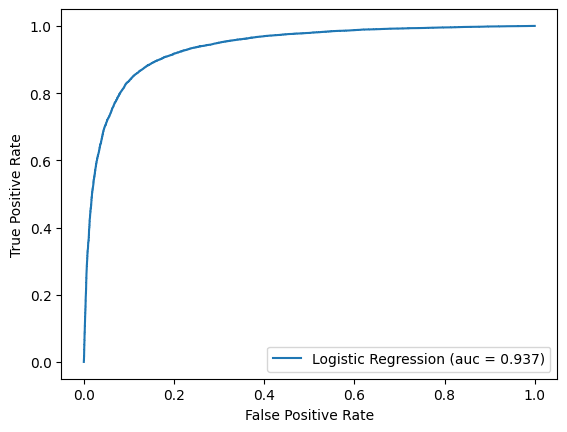

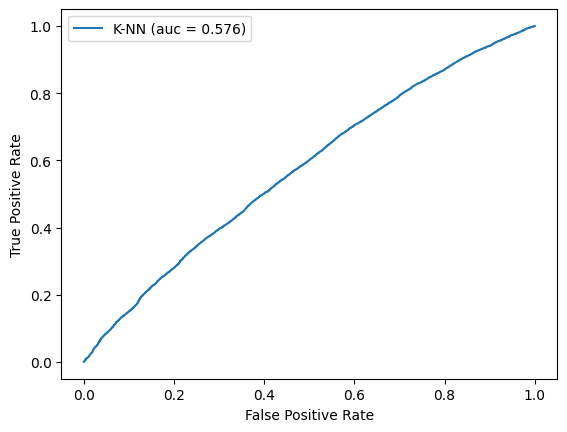

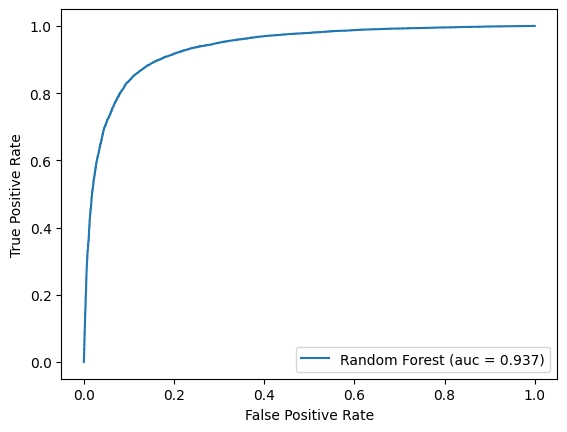

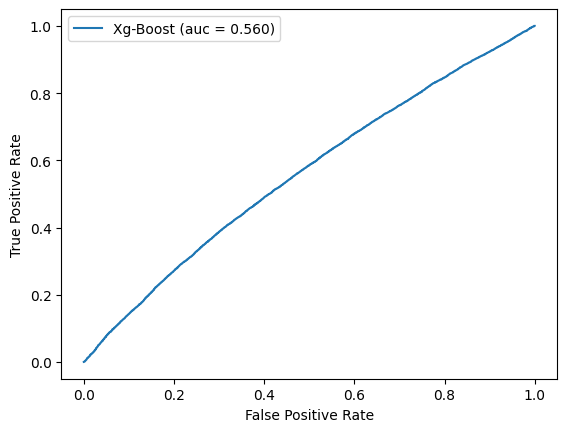

<Figure size 640x480 with 0 Axes>

In [95]:
# Roc Curves
os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/ROC/BOW/')

models = [model_lr_BOW_bin, model_knn_BOW_bin, model_rf_BOW_bin, xgboost_holdout_BOW_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']

for model, name in zip(models, models_name):
    y_pred = model.predict_proba(X_test_BOW_bin)[:,1]
    auc = roc_auc_score(y_test_bin, y_pred)
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred)
    plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % (name, auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(name+"_ROC_curve_BOW.png")
    plt.show()
    plt.clf()

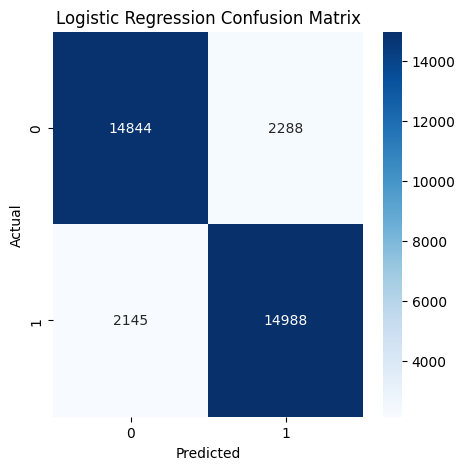

<Figure size 640x480 with 0 Axes>

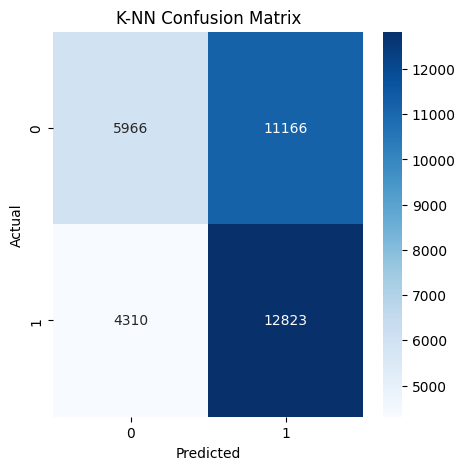

<Figure size 640x480 with 0 Axes>

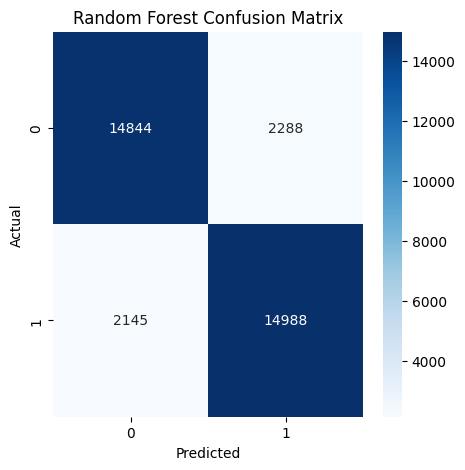

<Figure size 640x480 with 0 Axes>

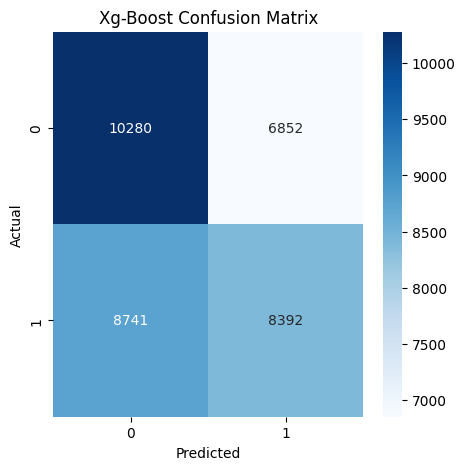

<Figure size 640x480 with 0 Axes>

In [97]:
# Confusion matrices
os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/Confusion_matrices/BOW')

models = [model_lr_BOW_bin, model_knn_BOW_bin, model_rf_BOW_bin, xgboost_holdout_BOW_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']

# Create confusion matrices and save the plots
for model, name in zip(models, models_name):
    y_pred = model.predict(X_test_BOW_bin)
    cm = confusion_matrix(y_test_bin, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(name+' Confusion Matrix')
    plt.savefig(name+"_confusion_matrix_BOW.png")
    plt.show()
    plt.clf()

## **2 - TF-IDF**

In [ ]:
tv_bin = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model_bin = tv_bin.fit(X_train_bin.astype(str))
X_train_TFIDF_bin = tv_bin.transform(X_train_bin.astype(str))

In [ ]:
# Eseguo SVD - da runnare
n_components = 5000
tSVD_TFIDF_bin = TruncatedSVD(n_components = n_components)
SVD_TFIDF_5000_bin = tSVD_TFIDF_bin.fit(X_train_TFIDF)

# Calcolo varianza cumulata delle componenti
cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

# Salvo SVD su disco
# joblib.dump(SVD_TFIDF_5000, "H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_TFIDF_5000_bin.joblib")
model_path = '/content/gdrive/MyDrive/TextMiningProject/SVD_TFIDF_5000_bin.joblib'
joblib.dump(SVD_TFIDF_5000_bin, model_path)

In [ ]:
# Load SVD
# SVD_TFIDF_5000_bin = joblib.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_TFIDF_5000_bin.joblib")
# cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

In [ ]:
# Grafico varianza cumulata
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.show()

In [ ]:
threshold = 0.85
n_components = np.argmax(cum_var >= threshold) + 1
print("Numero di componenti necessariea spiegare una varianza pari all'85% sono : ", n_components)

In [ ]:
# Fit optimal SVD
tSVD_TFID_bin = TruncatedSVD(n_components =) #Inseire numero componenti che la print sopra ti indica 
SVD_TFIDF_bin = tSVD_TFIDF.fit(X_train_TFIDF)

In [ ]:
# Apply the trasformation on the training and test set
X_train_TFIDF_bin = tSVD_TFID_bin.transform(X_train_bin.astype(str))

X_test_TFIDF_bin = tv_model_bin.transform(X_test_bin.astype(str))
X_test_TFIDF_bin = SVD_TFIDF_bin.transform(X_test_TFIDF_bin)

In [ ]:
# Save final datasets
np.save('/content/gdrive/MyDrive/TextMiningProject/Dataset_TFIDF/X_train_TFIDF_bin.npy', X_train_TFIDF_bin)
np.save('/content/gdrive/MyDrive/TextMiningProject/Dataset_TFIDF/X_test_TFIDF_bin.npy', X_test_TFIDF_bin)

In [15]:
# Load final datasets
X_train_TFIDF_bin = np.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_TFIDF/X_train_TFIDF_bin.npy', allow_pickle=True)
X_test_TFIDF_bin = np.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_TFIDF/X_test_TFIDF_bin.npy', allow_pickle=True)

### Algorithm Implementation

#### Logistic Regression

In [ ]:
# Regressione logistica con ottimizzazione degli iperparametri
model = LogisticRegression(random_state=1)

# Iperparametri "critici" da ottimizzare 
solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['None', 'l2']
c_values = [500, 200, 100, 50, 10, 1.0]

# Definisco la griglia di ricerca
grid = dict(penalty=penalty,C=c_values)

# Start the clock, train the classifier, then stop the clock
start = time()

# CV and Tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
grid_result = random_search.fit(X_train_TFIDF_bin, y_train)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/lrr_gridsearch_TFIDF_bin.joblib'
# joblib.dump(grid_result, path)

model_path = '/content/gdrive/MyDrive/TextMiningProject/logreg_gridsearch_TFIDF_bin.joblib'
joblib.dump(grid_result, model_path)

In [27]:
# Caricamento del risultato del tuning

path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/TFIDF/logreg_gridsearch_TFIDF_bin.joblib'
loaded_grid_search = joblib.load(path)
# model_path = '/content/gdrive/MyDrive/TextMiningProject/logreg_gridsearch_TFIDF_bin.joblib'
# loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

#Salvo il modello con le migliori performance
model_lr_TFIDF_bin = loaded_grid_search.best_estimator_

Best result: 0.873097 using {'penalty': 'l2', 'C': 1.0}


#### KNN

In [ ]:
model = KNeighborsClassifier(weights='distance')

# Parametri critici da
n_neighbors = range(1, 21, 1)

# Definisco la griglia di ricerca
grid = dict(n_neighbors=n_neighbors)

# Start the clock, train the classifier, then stop the clock
start = time()
random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
grid_result = random_search.fit(X_train_TFIDF_bin, y_train)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning

# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_TFIDF_bin.joblib'
# loaded_grid_search = joblib.load(path)
model_path = '/content/gdrive/MyDrive/TextMiningProject/knn_gridsearch_TFIDF_bin.joblib'
joblib.dump(grid_result, model_path)

In [23]:
# Caricamento del risultato del tuning

path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/TFIDF/knn_gridsearch_TFIDF_bin.joblib'
loaded_grid_search = joblib.load(path)
# model_path = '/content/gdrive/MyDrive/TextMiningProject/knn_gridsearch_TFIDF_bin.joblib'
# loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_knn_TFIDF_bin = loaded_grid_search.best_estimator_

Best result: 0.624833 using {'n_neighbors': 10}


#### Random Forest

In [ ]:
# Random Forest
model = RandomForestClassifier()

# Parametri 'critici' da ottimizzare
max_depth = [1, 2, 3, 4, 5, 6, 7]
n_estimators = [10, 100, 200, 400, 600, 800, 1000]
max_features = ['sqrt', 'log2']
# Definisco la griglia di ricerca 
grid = dict(n_estimators=n_estimators,max_features=max_features)

# Start the clock, train the classifier, then stop the clock
start = time()

random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
grid_result = random_search.fit(X_train_TFIDF_bin, y_train)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/rf_gridsearch_TFIDF_bin.joblib'
# joblib.dump(grid_result, path)

model_path = '/content/gdrive/MyDrive/TextMiningProject/rf_gridsearch_TFIDF_bin.joblib'
joblib.dump(grid_result, model_path)

In [24]:

# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/TFIDF/rf_gridsearch_TFIDF_bin.joblib'
loaded_grid_search = joblib.load(path)

# model_path = '/content/gdrive/MyDrive/TextMiningProject/rf_gridsearch_TFIDF_bin.joblib'
# loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_rf_TFIDF_bin = loaded_grid_search.best_estimator_

Best result: 0.776038 using {'n_estimators': 800, 'max_features': 'sqrt'}


#### XGBoost

In [35]:
# Holdout 
model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective='binary:logistic')
model_xgboost = model.fit(X_train_TFIDF_bin, y_train_bin)

# Save hold out
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/TFIDF/model_xgboost_TFIDF_bin.json'
joblib.dump(model_xgboost, path)

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/TFIDF/model_xgboost_TFIDF_bin.json']

In [36]:
# Load model
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/TFIDF/model_xgboost_TFIDF_bin.json'
model_xgboost_TFIDF_bin = joblib.load(path)

### Analyis of the results

In [37]:
models = [model_lr_TFIDF_bin, model_knn_TFIDF_bin, model_rf_TFIDF_bin, model_xgboost_TFIDF_bin]

# Make a prediction on the test set
results = []
for model in models:
    y_pred = model.predict(X_test_TFIDF_bin)
    acc = accuracy_score(y_test_bin, y_pred)
    prec = precision_score(y_test_bin, y_pred, average='macro')
    recall = recall_score(y_test_bin, y_pred, average='macro')
    f1 = f1_score(y_test_bin, y_pred, average='macro')
    results.append([acc, prec, recall, f1])

# Dataframe with the results for each model
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', 'Random Forest', 'XGBOOST model']
print(df_results)

               Accuracy  Precision    Recall  F1 Score
LR model       0.882008   0.882009  0.882008  0.882008
KNN model      0.641675   0.646453  0.641678  0.638732
Random Forest  0.789756   0.790627  0.789757  0.789599
XGBOOST model  0.828426   0.828488  0.828426  0.828417


In [41]:
# Save the results dataframe
df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Results/df_results_TFIDF_bin.csv')

In [44]:
# Load results dataframe
df_results_TFIDF_bin= pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Results/df_results_TFIDF_bin.csv')
print(df_results_TFIDF_bin)

      Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0       LR model  0.882008   0.882009  0.882008  0.882008
1      KNN model  0.641675   0.646453  0.641678  0.638732
2  Random Forest  0.789756   0.790627  0.789757  0.789599
3  XGBOOST model  0.828426   0.828488  0.828426  0.828417


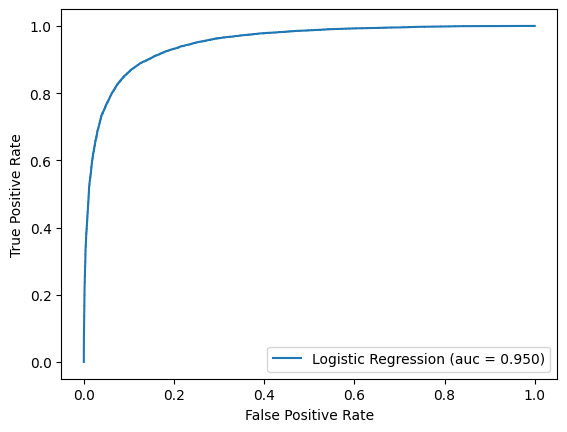

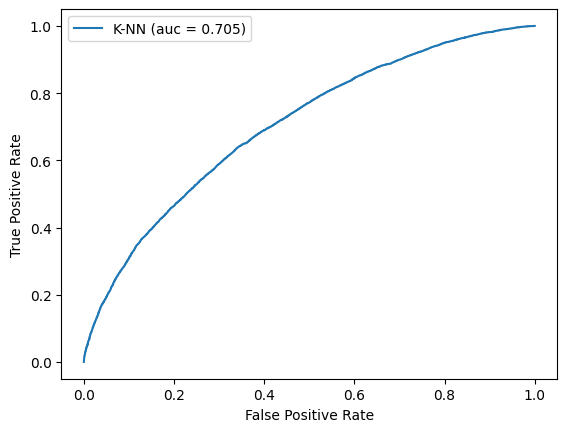

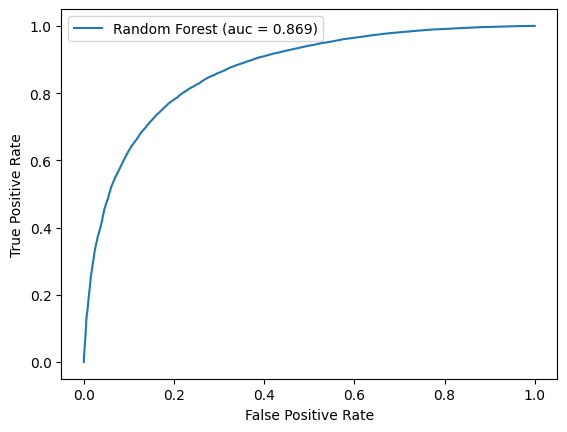

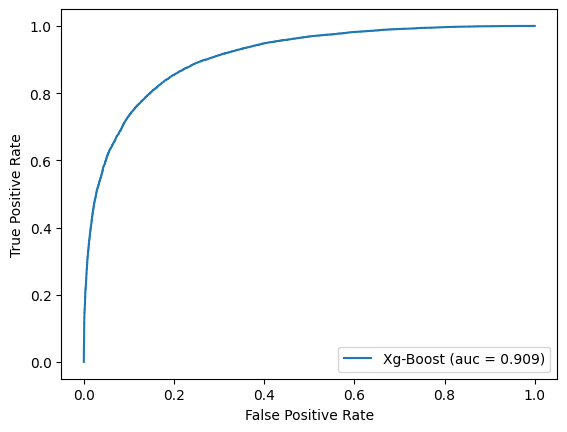

<Figure size 640x480 with 0 Axes>

In [48]:
# Roc Curve
os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/ROC/TFIDF')

models = [model_lr_TFIDF_bin, model_knn_TFIDF_bin, model_rf_TFIDF_bin, model_xgboost_TFIDF_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']

for model, name in zip(models, models_name):
    y_pred = model.predict_proba(X_test_TFIDF_bin)[:,1]
    auc = roc_auc_score(y_test_bin, y_pred)
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred)
    plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % (name, auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(name+"_ROC_curve.png")
    plt.show()
    plt.clf()

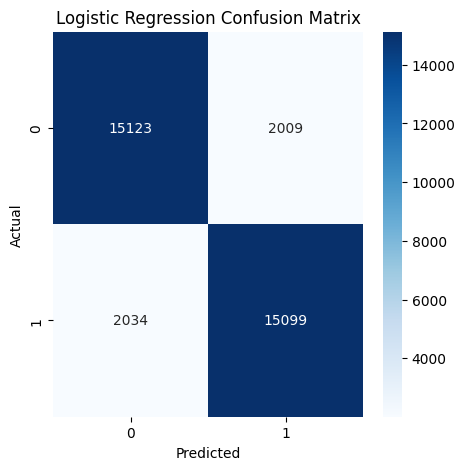

<Figure size 640x480 with 0 Axes>

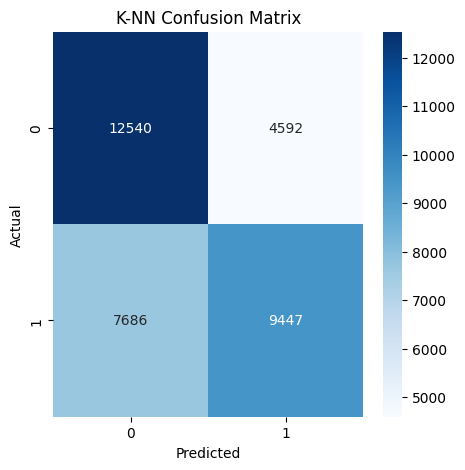

<Figure size 640x480 with 0 Axes>

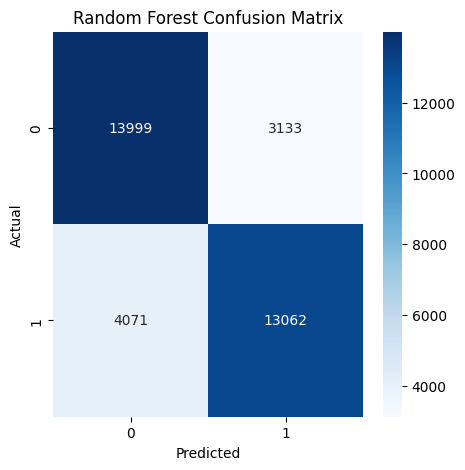

<Figure size 640x480 with 0 Axes>

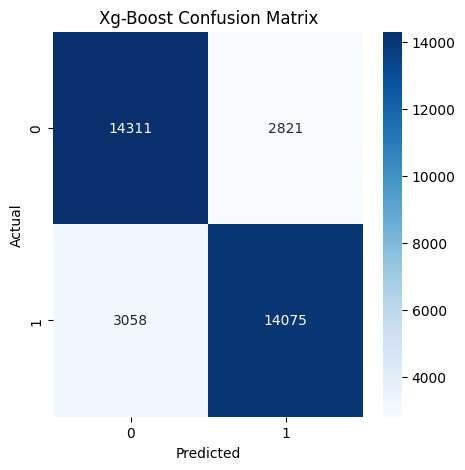

<Figure size 640x480 with 0 Axes>

In [50]:
# Confusion matrices
os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/Confusion_matrices/TFIDF')

models = [model_lr_TFIDF_bin, model_knn_TFIDF_bin, model_rf_TFIDF_bin, model_xgboost_TFIDF_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']


for model, name in zip(models, models_name):
    y_pred = model.predict(X_test_TFIDF_bin)
    cm = confusion_matrix(y_test_bin, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(name+' Confusion Matrix')
    plt.savefig(name+"_confusion_matrix.png")
    plt.show()
    plt.clf()

### **3 - Word2Vec**

In [19]:
w2v_model_bin = gensim.models.Word2Vec(X_train_bin, vector_size=300, window=8, min_count=2)

In [20]:
words_bin = set(w2v_model_bin.wv.index_to_key) 

# X_train_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
#                          for ls in X_train_bin])
# X_test_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
#                          for ls in X_test_bin])

In [105]:
# Carico X_train_vect e X_test_vect
X_train_bin_vect = np.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_W2V/X_train_bin_vect.npy", allow_pickle=True)
X_test_bin_vect = np.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Dataset_W2V/X_test_bin_vect.npy", allow_pickle=True)

In [106]:
X_train_bin_vect_avg = []
for v in X_train_bin_vect:
    if v.size:
        X_train_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_train_bin_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_bin_vect_avg = []
for v in X_test_bin_vect:
    if v.size:
        X_test_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_test_bin_vect_avg.append(np.zeros(300, dtype=float))

#### Algorithm Implementation

##### Logistic regression

In [26]:
# Regressione logistica con ottimizzazione degli iperparametri
model = LogisticRegression(random_state=1)

# Iperparametri "critici" da ottimizzare 
solvers = ['lbfgs', 'sag', 'saga']
penalty = ['None', 'l2']
c_values = [500, 200, 100, 50, 10]

# Definisco la griglia di ricerca
grid = dict(penalty=penalty,C=c_values, solver = solvers)

# Start the clock, train the classifier, then stop the clock
start = time()

# CV and Tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
grid_result = random_search.fit(X_train_bin_vect_avg, y_train_bin)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/lrr_gridsearch_W2V_bin.joblib'
joblib.dump(grid_result, path)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ..C=200, penalty=None, solver=saga;, score=0.000 total time=   0.0s
[CV 2/2] END ..C=200, penalty=None, solver=saga;, score=0.000 total time=   0.0s
[CV 1/2] END ..C=500, penalty=None, solver=saga;, score=0.000 total time=   0.0s
[CV 2/2] END ..C=500, penalty=None, solver=saga;, score=0.000 total time=   0.0s
[CV 1/2] END .C=200, penalty=None, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 2/2] END .C=200, penalty=None, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 1/2] END .C=500, penalty=None, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 2/2] END .C=500, penalty=None, solver=lbfgs;, score=0.000 total time=   0.0s
[CV 1/2] END ......C=50, penalty=l2, solver=sag;, score=0.854 total time=   9.1s
[CV 2/2] END ......C=50, penalty=l2, solver=sag;, score=0.857 total time=  10.5s
[CV 1/2] END ....C=500, penalty=l2, solver=saga;, score=0.853 total time=  11.5s
[CV 2/2] END ....C=500, penalty=l2, solver=saga;,

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/lrr_gridsearch_W2V_bin.joblib']

In [99]:
# Caricamento del risultato del tuning

path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/lrr_gridsearch_W2V_bin.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

#Salvo il modello con le migliori performance
model_lr_W2V_bin = loaded_grid_search.best_estimator_

Best result: 0.855399 using {'solver': 'sag', 'penalty': 'l2', 'C': 50}


##### Random Forest

In [28]:
# Random Forest
model = RandomForestClassifier()

# # Parametri 'critici' da ottimizzare
n_estimators = [10, 50, 70, 100, 200, 300, 400, 500]
max_features = ['sqrt', 'log2']
# #Definisco la griglia di ricerca 
grid = dict(n_estimators=n_estimators,max_features=max_features)

# # Start the clock, train the classifier, then stop the clock
start = time()

random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
grid_result = random_search.fit(X_train_bin_vect_avg, y_train_bin) 
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
joblib.dump(grid_result, 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/rf_gridsearch_W2V_bin.joblib')

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_features=sqrt, n_estimators=50;, score=0.830 total time=  44.0s
[CV 2/2] END max_features=sqrt, n_estimators=50;, score=0.833 total time=  44.0s
[CV 1/2] END max_features=sqrt, n_estimators=100;, score=0.837 total time= 1.5min
[CV 2/2] END max_features=sqrt, n_estimators=100;, score=0.838 total time= 1.5min
[CV 1/2] END max_features=log2, n_estimators=500;, score=0.840 total time= 3.4min
[CV 2/2] END max_features=log2, n_estimators=500;, score=0.842 total time= 4.9min
[CV 1/2] END max_features=sqrt, n_estimators=10;, score=0.798 total time=  12.8s
[CV 2/2] END max_features=sqrt, n_estimators=10;, score=0.801 total time=   8.7s
[CV 1/2] END max_features=sqrt, n_estimators=500;, score=0.841 total time=10.3min
[CV 2/2] END max_features=sqrt, n_estimators=500;, score=0.841 total time= 8.9min
[CV 1/2] END max_features=sqrt, n_estimators=200;, score=0.839 total time= 3.5min
[CV 2/2] END max_features=sqrt, n_estimato

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/rf_gridsearch_W2V_bin.joblib']

In [56]:

# # Caricamento del risultato del tuning
loaded_grid_search = joblib.load('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/rf_gridsearch_W2V_bin.joblib')

# # Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# # Salvo il modello con le migliori perfomance
model_rf_W2V_bin = loaded_grid_search.best_estimator_

Best result: 0.840853 using {'n_estimators': 500, 'max_features': 'log2'}


##### KNN

In [ ]:
model = KNeighborsClassifier(weights='distance')
# Parametri critici da
n_neighbors = range(1, 21, 1)

# Definisco la griglia di ricerca
grid = dict(n_neighbors=n_neighbors)

# Start the clock, train the classifier, then stop the clock
start = time()
random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
#grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2, scoring='accuracy',error_score=0)
grid_result = random_search.fit(X_train_bin_vect_avg, y_train_bin)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning

path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/knn_gridsearch_W2V_bin.joblib'
joblib.dump(grid_result, path)

In [100]:
# Caricamento del risultato del tuning

path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/knn_gridsearch_W2V_bin.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_knn_W2V_bin = loaded_grid_search.best_estimator_

Best result: 0.817263 using {'n_neighbors': 19}


##### XGBoost

In [33]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

le = LabelEncoder()
y_train_xg = le.fit_transform(y_train_bin)

model = XGBClassifier(sampling_method = 'gradient_based', max_depth = 6, eta = 0.2, n_jobs=-1, tree_method = 'hist', objective='binary:logistic')
model_xgboost_W2V_bin = model.fit(X_train_bin_vect_avg, y_train_xg)

# Salvataggio dei risultati dell'holdout
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/xgboost_holdout_W2V_bin.joblib'
joblib.dump(model_xgboost_W2V_bin, path)

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/xgboost_holdout_W2V_bin.joblib']

In [101]:
# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/Classificazione_binaria/W2V/xgboost_holdout_W2V_bin.joblib'
model_xgboost_W2V_bin = joblib.load(path)

# model_path = '/content/gdrive/MyDrive/TextMiningProject/xgboost_holdout_W2V.joblib'
# model_xgboost_W2V = joblib.load(model_path)

### Analysis of the results

In [37]:
models = [model_lr_W2V_bin, model_knn_W2V_bin, model_rf_W2V_bin, model_xgboost_W2V_bin]

# Make a predict on the test set
results = []
for model in models:
    if model == models[3]:
        y_test_bin_xg = le.fit_transform(y_test_bin)
        print(y_test_bin_xg)
        y_pred = model.predict(X_test_bin_vect_avg)
        acc = accuracy_score(y_test_bin_xg, y_pred)
        prec = precision_score(y_test_bin_xg, y_pred, average='macro')
        recall = recall_score(y_test_bin_xg, y_pred, average='macro')
        f1 = f1_score(y_test_bin_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_bin_vect_avg)
        acc = accuracy_score(y_test_bin, y_pred)
        prec = precision_score(y_test_bin, y_pred, average='macro')
        recall = recall_score(y_test_bin, y_pred, average='macro')
        f1 = f1_score(y_test_bin, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Datafram with results for each model
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', 'Random Forest model', 'XGBOOST model']
print(df_results)

[1 1 0 ... 0 1 0]
                     Accuracy  Precision    Recall  F1 Score
LR model             0.858952   0.859023  0.858952  0.858945
KNN model            0.824369   0.824379  0.824369  0.824368
Random Forest model  0.846374   0.846403  0.846374  0.846371
XGBOOST model        0.856793   0.856815  0.856793  0.856790


In [38]:
# Save dataframe
df_results.to_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_W2V_bin.csv')

In [102]:
# Load the results dtaframe
df_results_W2V_bin = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_results_W2V_bin.csv')
print(df_results_W2V_bin)

            Unnamed: 0  Accuracy  Precision    Recall  F1 Score
0             LR model  0.858952   0.859023  0.858952  0.858945
1            KNN model  0.824369   0.824379  0.824369  0.824368
2  Random Forest model  0.846374   0.846403  0.846374  0.846371
3        XGBOOST model  0.856793   0.856815  0.856793  0.856790


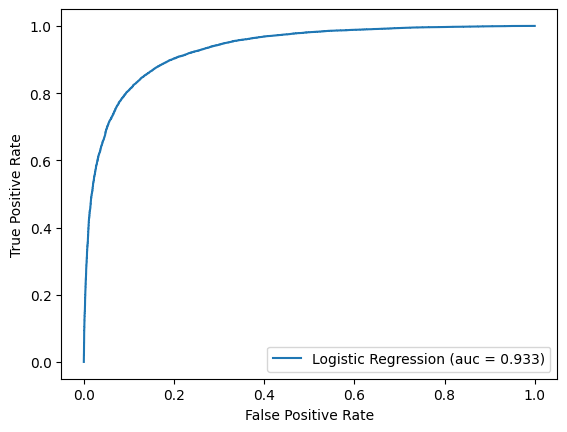

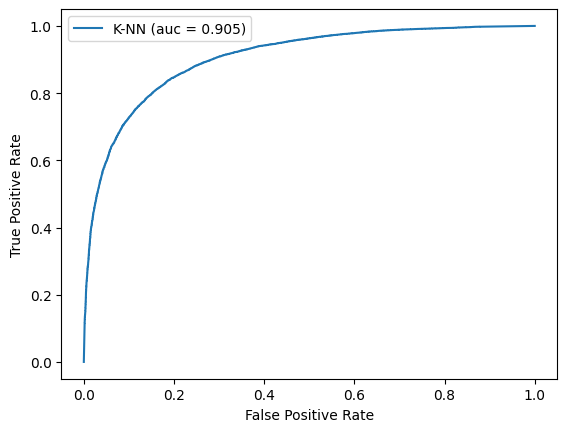

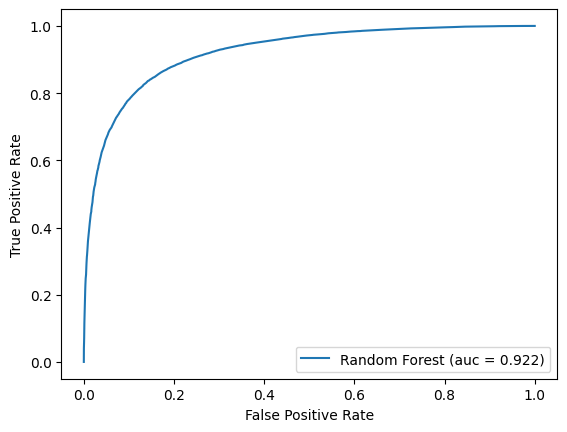

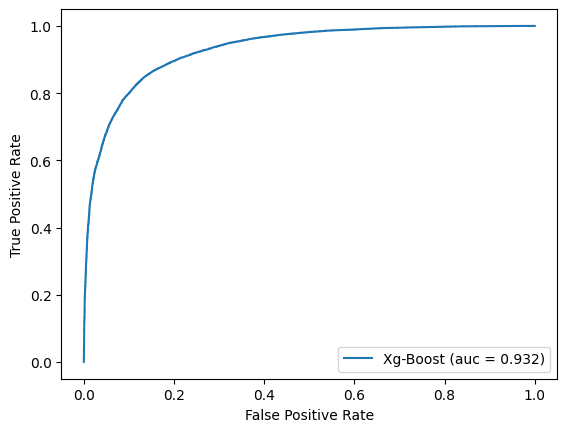

<Figure size 640x480 with 0 Axes>

In [109]:
# Roc curves
os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/ROC/W2V')

models = [model_lr_W2V_bin, model_knn_W2V_bin, model_rf_W2V_bin, model_xgboost_W2V_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']


for model, name in zip(models, models_name):
    y_pred = model.predict_proba(X_test_bin_vect_avg)[:,1]
    auc = roc_auc_score(y_test_bin, y_pred)
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred)
    plt.plot(fpr, tpr, label='%s (auc = %0.3f)' % (name, auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(name+"_ROC_curve.png")
    plt.show()
    plt.clf()

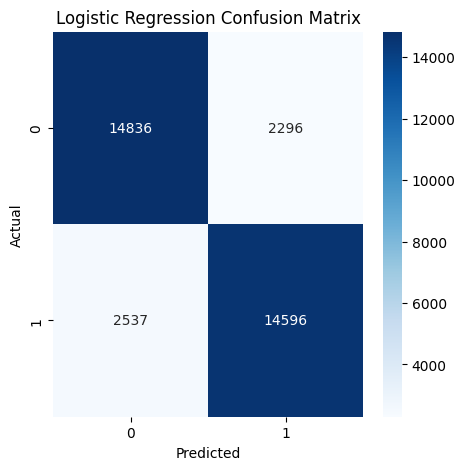

<Figure size 640x480 with 0 Axes>

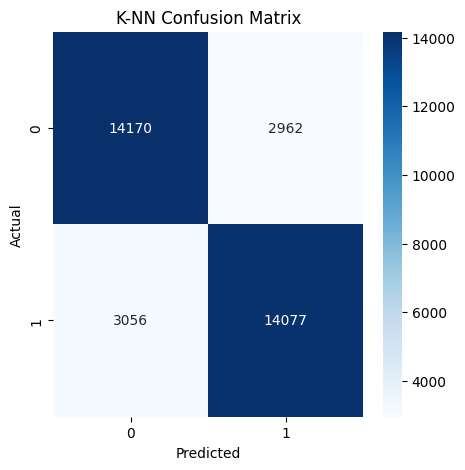

<Figure size 640x480 with 0 Axes>

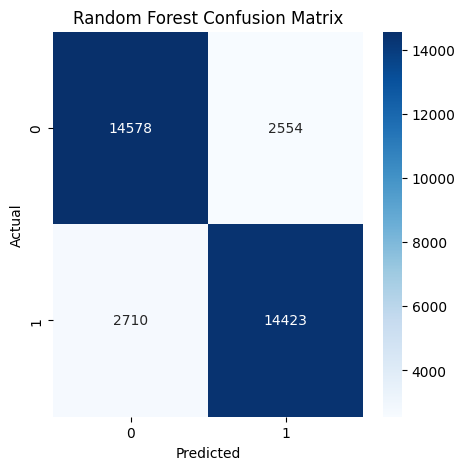

<Figure size 640x480 with 0 Axes>

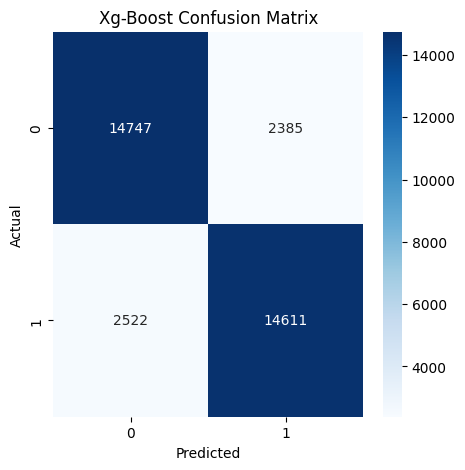

<Figure size 640x480 with 0 Axes>

In [114]:
# Confusion matrices
os.chdir('C:/Users/marco/OneDrive/UNIMIB_DataScience/99-PROJECTS/TMS22_Project/TextMining_Project/Plot_paper/Classificazione_Binaria/Confusion_matrices/W2V')

models = [model_lr_W2V_bin, model_knn_W2V_bin, model_rf_W2V_bin, model_xgboost_W2V_bin]
models_name = ['Logistic Regression', 'K-NN', 'Random Forest', 'Xg-Boost']

for model, name in zip(models, models_name):
    y_pred = model.predict(X_test_bin_vect_avg)
    cm = confusion_matrix(y_test_bin, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(name+' Confusion Matrix')
    plt.savefig(name+"_confusion_matrix.png")
    plt.show()
    plt.clf()